In [10]:
# CODE 1 — Install necessary libraries
!pip install librosa soundfile numpy sklearn --quiet

import numpy as np
import librosa
import soundfile as sf
from sklearn.cluster import KMeans


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [11]:
# CODE 2 — Load your audio file

audio_file = "/content/thank-for-watching-this-video-voice-174316.mp3"   # <-- use YOUR audio file
y, sr = librosa.load(audio_file, sr=16000)

print("Audio loaded:", audio_file)
print("Sampling rate:", sr)
print("Audio duration:", len(y)/sr, "seconds")


Audio loaded: /content/thank-for-watching-this-video-voice-174316.mp3
Sampling rate: 16000
Audio duration: 6.456 seconds


In [12]:
# CODE 3 — Extract MFCC features

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
mfcc = mfcc.T   # shape: (num_frames, 13)

num_frames = mfcc.shape[0]

print("MFCC shape:", mfcc.shape)


MFCC shape: (202, 13)


In [13]:
# CODE 4 — Choose number of hidden states (clusters)

K = 5   # hidden states (phoneme-like units)

print("Hidden states:", K)


Hidden states: 5


In [14]:
# CODE 5 — Unsupervised phoneme discovery using K-means

kmeans = KMeans(n_clusters=K, random_state=0)
hidden_states = kmeans.fit_predict(mfcc)

print("Hidden state sequence (first 50):")
print(hidden_states[:50])


Hidden state sequence (first 50):
[3 3 3 2 2 2 4 4 2 2 2 0 2 4 4 1 2 2 1 1 1 0 0 0 0 1 1 1 4 4 4 2 2 2 2 1 0
 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [15]:
# CODE 6 — Build transition matrix A automatically

A = np.zeros((K, K))

for i in range(num_frames - 1):
    A[hidden_states[i], hidden_states[i+1]] += 1

# Normalize rows
for i in range(K):
    if A[i].sum() > 0:
        A[i] /= A[i].sum()

print("Transition Matrix A:")
print(A)


Transition Matrix A:
[[0.44       0.12       0.24       0.12       0.08      ]
 [0.21428571 0.57142857 0.07142857 0.         0.14285714]
 [0.04597701 0.03448276 0.79310345 0.         0.12643678]
 [0.18181818 0.         0.09090909 0.72727273 0.        ]
 [0.04       0.12       0.18       0.         0.66      ]]


In [16]:
# CODE 7 — Build emission matrix B

# Here observations = hidden states (self-emission model)
B = np.eye(K)

print("Emission Matrix B:")
print(B)
""

Emission Matrix B:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


''

In [17]:
# CODE 8 — Initial probabilities

pi = np.zeros(K)
pi[hidden_states[0]] = 1.0

print("Initial π:", pi)


Initial π: [0. 0. 0. 1. 0.]


In [9]:
# CODE 9 — Run Viterbi

path, prob = viterbi(obs_seq, A, B, pi)

decoded_phonemes = [states[i] for i in path]

print("\nMost likely hidden state path:")
print(decoded_phonemes)

print("\nProbability of path:", prob)



Most likely hidden state path:
['h', 'e', 'l', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o

In [18]:
# CODE 9 — Viterbi algorithm for decoded hidden state path

def viterbi(obs, A, B, pi):
    T = len(obs)
    N = len(pi)

    delta = np.zeros((T, N))
    psi = np.zeros((T, N), dtype=int)

    # Initialization
    delta[0] = pi * B[:, obs[0]]

    # Recursion
    for t in range(1, T):
        for j in range(N):
            probs = delta[t-1] * A[:, j]
            psi[t, j] = np.argmax(probs)
            delta[t, j] = np.max(probs) * B[j, obs[t]]

    # Termination
    P_star = np.max(delta[-1])
    last_state = np.argmax(delta[-1])

    # Backtrack
    path = [last_state]
    for t in range(T-1, 0, -1):
        path.insert(0, psi[t, path[0]])

    return path, P_star


In [19]:
# CODE 10 — Run Viterbi

obs_seq = hidden_states   # observations = cluster IDs

viterbi_path, prob = viterbi(obs_seq, A, B, pi)

print("\nDecoded Hidden State Path (first 50):")
print(viterbi_path[:50])

print("\nProbability of best path:", prob)



Decoded Hidden State Path (first 50):
[np.int64(3), np.int64(3), np.int64(3), np.int64(2), np.int64(2), np.int64(2), np.int64(4), np.int64(4), np.int64(2), np.int64(2), np.int64(2), np.int64(0), np.int64(2), np.int64(4), np.int64(4), np.int64(1), np.int64(2), np.int64(2), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(4), np.int64(4), np.int64(4), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(0), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2)]

Probability of best path: 7.863618274589022e-81


In [20]:
# VIS CODE 1 — imports and helpers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import librosa
import librosa.display
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

# helper: convert frame index -> time (seconds)
def frame_to_time(frame_idx, hop_length=512, sr=16000):
    return (frame_idx * hop_length) / sr

# If your MFCC was computed with default hop_length=512 (librosa),
# set this to the hop_length you used. Adjust if different.
HOP_LENGTH = 512


In [21]:
# VIS CODE 2 — Viterbi that returns delta & psi (log-space)
import math

def viterbi_with_matrices(obs, A, B, pi, eps=1e-12):
    """
    obs: sequence of discrete observations (0..M-1) length T
    A: (N,N) transition matrix
    B: (N,M) emission matrix (probabilities)
    pi: (N,) initial probabilities
    Returns: path, P_star (prob), log_delta (T x N), psi (T x N)
    """
    T = len(obs)
    N = A.shape[0]

    # convert to log space; avoid log(0)
    logA = np.log(A + eps)
    logB = np.log(B + eps)
    logpi = np.log(pi + eps)

    log_delta = np.full((T, N), -np.inf)
    psi = np.zeros((T, N), dtype=int)

    # init
    log_delta[0, :] = logpi + logB[:, obs[0]]

    # recursion
    for t in range(1, T):
        for j in range(N):
            # compute vector of candidate log-probabilities from each i -> j
            candidates = log_delta[t-1, :] + logA[:, j]
            psi[t, j] = int(np.argmax(candidates))
            log_delta[t, j] = np.max(candidates) + logB[j, obs[t]]

    # termination
    last_idx = int(np.argmax(log_delta[T-1, :]))
    P_star_log = float(np.max(log_delta[T-1, :]))

    # backtrack
    path = [last_idx]
    for t in range(T-1, 0, -1):
        path.insert(0, psi[t, path[0]])

    return path, math.exp(P_star_log), log_delta, psi


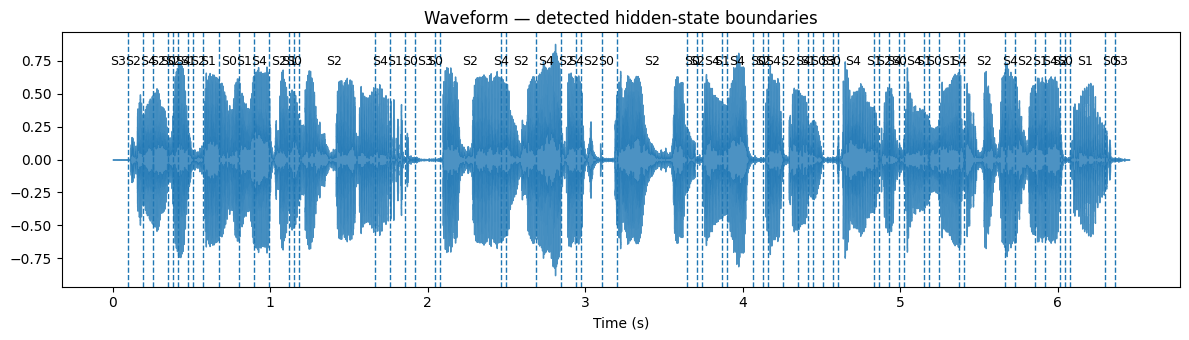

In [22]:
# VIS CODE 3 — waveform + segmentation boundaries + labels
# Ensure y, sr, hidden_states exist
T_frames = len(hidden_states)
times = np.arange(T_frames) * HOP_LENGTH / sr

# find change indices where hidden state changes
change_idx = np.where(np.diff(hidden_states) != 0)[0]  # indices of frame before change
boundaries = (change_idx + 1)  # frame index where next state starts

plt.figure(figsize=(12, 3.5))
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.title("Waveform — detected hidden-state boundaries")
plt.xlabel("Time (s)")

# draw vertical lines and label segments with state id
for b in boundaries:
    t = (b * HOP_LENGTH) / sr
    plt.axvline(x=t, linestyle='--', linewidth=1)

# annotate midpoints with state label
segment_starts = np.concatenate(([0], boundaries))
segment_ends = np.concatenate((boundaries, [T_frames]))
for s, e in zip(segment_starts, segment_ends):
    mid_frame = (s + e) // 2
    mid_time = mid_frame * HOP_LENGTH / sr
    plt.text(mid_time, 0.9 * np.max(np.abs(y)), f"S{hidden_states[mid_frame]}",
             ha='center', va='top', fontsize=9)

plt.tight_layout()
plt.show()


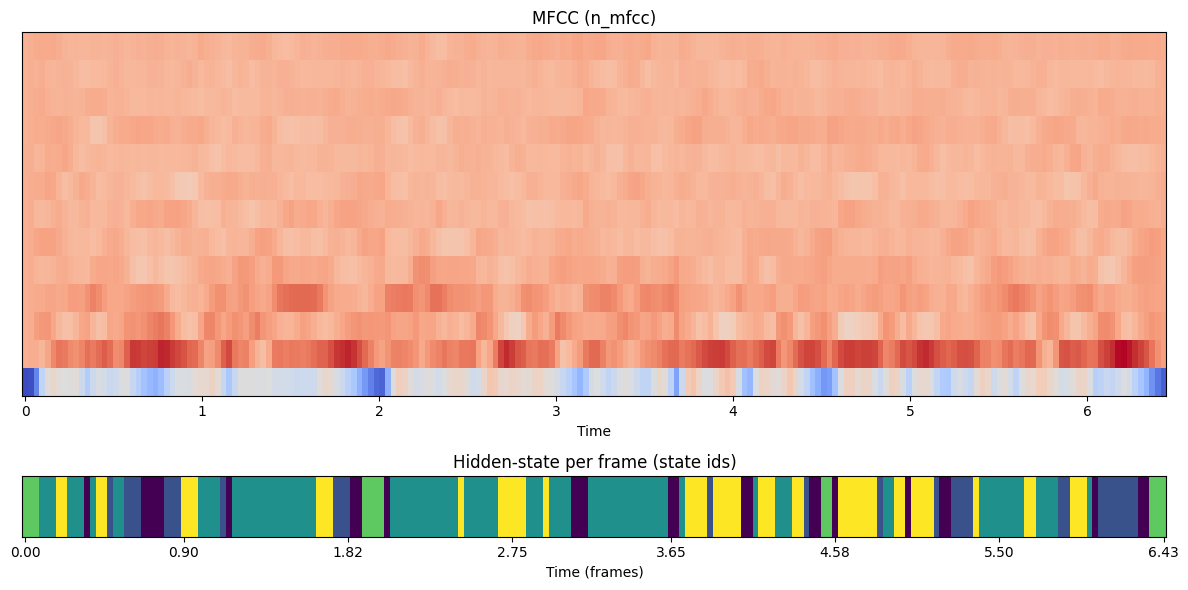

In [23]:
# VIS CODE 4 — MFCC spectrogram + state-bar
mfcc_T = mfcc.T  # (n_mfcc x T)
fig, ax = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios':[6, 1]})

librosa.display.specshow(mfcc_T, x_axis='time', sr=sr, hop_length=HOP_LENGTH, ax=ax[0])
ax[0].set_title("MFCC (n_mfcc)")

# state bar: plot hidden_states as an image row
state_row = np.expand_dims(hidden_states, axis=0)  # 1 x T
# Create a discrete colormap with K distinct colors
K = len(np.unique(hidden_states))
cmap = plt.get_cmap('tab10', K)
im = ax[1].imshow(state_row, aspect='auto', interpolation='nearest')
ax[1].set_yticks([])
ax[1].set_xlabel("Time (frames)")
# set x ticks to seconds
num_xticks = 8
xticks = np.linspace(0, state_row.shape[1]-1, num_xticks).astype(int)
xtick_labels = [f"{(t*HOP_LENGTH)/sr:.2f}" for t in xticks]
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xtick_labels)
ax[1].set_title("Hidden-state per frame (state ids)")

plt.tight_layout()
plt.show()


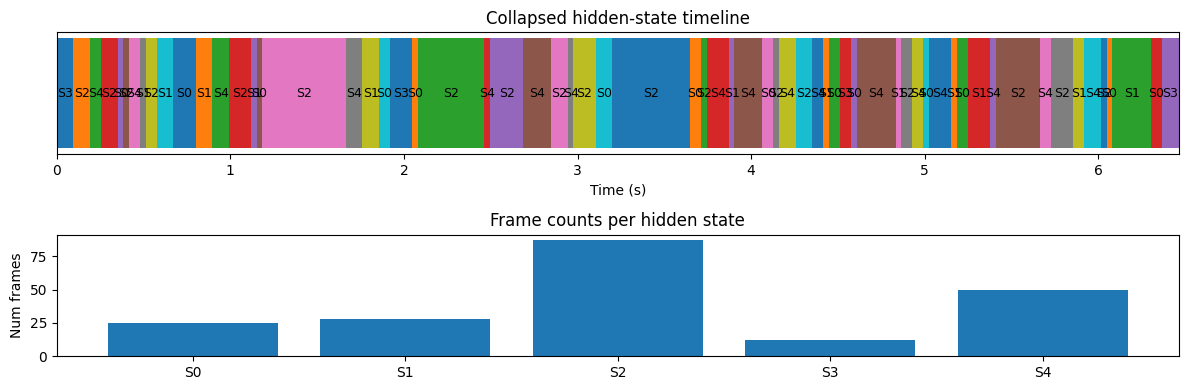

In [24]:
# VIS CODE 5 — timeline of consecutive states and counts
# Build segments (start_time, end_time, state)
segments = []
s = 0
for i in range(1, len(hidden_states)):
    if hidden_states[i] != hidden_states[i-1]:
        segments.append((s, i-1, int(hidden_states[s])))
        s = i
segments.append((s, len(hidden_states)-1, int(hidden_states[s])))

fig, ax = plt.subplots(2,1, figsize=(12,4), gridspec_kw={'height_ratios':[1,1]})
# timeline
for seg in segments:
    start_frame, end_frame, st = seg
    start = start_frame * HOP_LENGTH / sr
    end = (end_frame + 1) * HOP_LENGTH / sr
    ax[0].barh(0, width=end-start, left=start, height=0.4)
    ax[0].text((start+end)/2, 0, f"S{st}", ha='center', va='center', fontsize=9)
ax[0].set_yticks([])
ax[0].set_xlim(0, len(hidden_states)*HOP_LENGTH/sr)
ax[0].set_title("Collapsed hidden-state timeline")
ax[0].set_xlabel("Time (s)")

# counts per state
unique, counts = np.unique(hidden_states, return_counts=True)
ax[1].bar([f"S{u}" for u in unique], counts)
ax[1].set_title("Frame counts per hidden state")
ax[1].set_ylabel("Num frames")

plt.tight_layout()
plt.show()


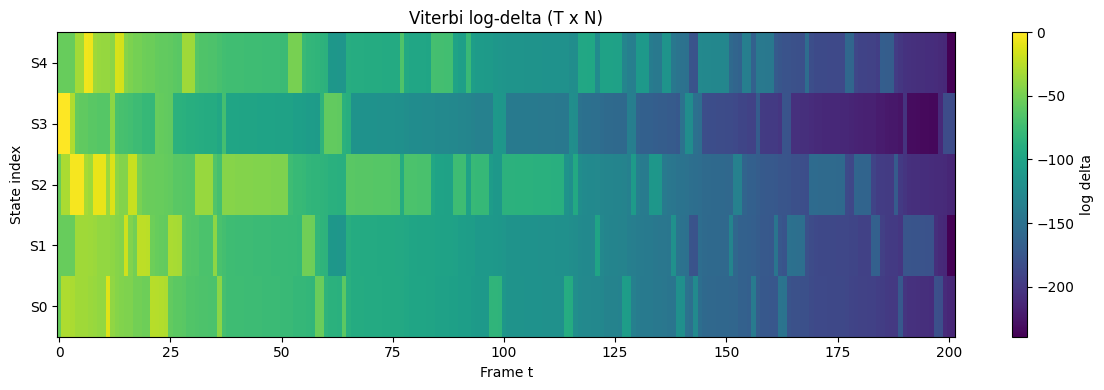

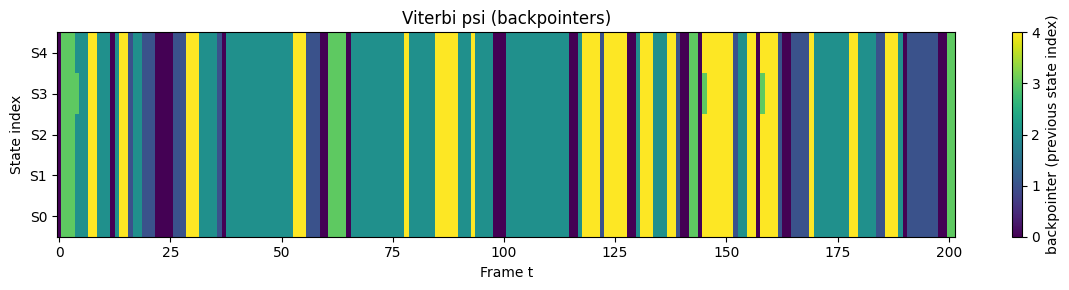

In [25]:
# VIS CODE 6 — compute viterbi matrices then plot them
# obs_seq should be discrete observations; in unsupervised pipeline obs_seq = hidden_states
obs_seq = hidden_states
path, prob, log_delta, psi = viterbi_with_matrices(obs_seq, A, B, pi)

# Plot log-delta as heatmap
plt.figure(figsize=(12,4))
plt.imshow(log_delta.T, aspect='auto', origin='lower')
plt.colorbar(label='log delta')
plt.xlabel('Frame t')
plt.ylabel('State index')
plt.title('Viterbi log-delta (T x N)')
plt.yticks(np.arange(A.shape[0]), [f"S{i}" for i in range(A.shape[0])])
plt.tight_layout()
plt.show()

# Plot psi (backpointers)
plt.figure(figsize=(12,3))
plt.imshow(psi.T, aspect='auto', origin='lower')
plt.colorbar(label='backpointer (previous state index)')
plt.xlabel('Frame t')
plt.ylabel('State index')
plt.title('Viterbi psi (backpointers)')
plt.yticks(np.arange(A.shape[0]), [f"S{i}" for i in range(A.shape[0])])
plt.tight_layout()
plt.show()


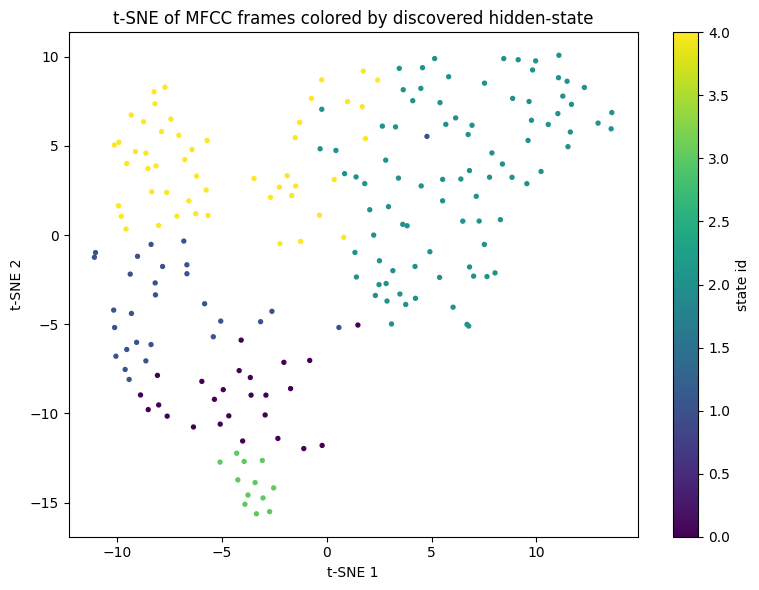

In [26]:
# VIS CODE 7 — t-SNE scatter of MFCC frames colored by cluster
# Subsample if too many frames for faster plotting
max_points = 3000
idx = np.linspace(0, mfcc.shape[0]-1, min(mfcc.shape[0], max_points)).astype(int)
mfcc_sub = mfcc[idx]
states_sub = hidden_states[idx]

tsne = TSNE(n_components=2, perplexity=30, random_state=0, init='pca', learning_rate='auto')
Z = tsne.fit_transform(mfcc_sub)

plt.figure(figsize=(8,6))
scatter = plt.scatter(Z[:,0], Z[:,1], c=states_sub, s=8)
plt.title("t-SNE of MFCC frames colored by discovered hidden-state")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='state id')
plt.tight_layout()
plt.show()


In [27]:
# VIS CODE 8 — save segmentation timestamps
import csv
out_csv = "segmentation_timestamps.csv"
with open(out_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["segment_idx","start_time_s","end_time_s","state_id"])
    for idx, seg in enumerate(segments):
        s_frame, e_frame, st = seg
        start_time = s_frame * HOP_LENGTH / sr
        end_time = (e_frame+1) * HOP_LENGTH / sr
        writer.writerow([idx, f"{start_time:.4f}", f"{end_time:.4f}", st])
print("Saved segmentation to", out_csv)


Saved segmentation to segmentation_timestamps.csv
